In [11]:
import pystan
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import arviz

sns.set()  # Nice plot aesthetic
np.random.seed(101)

## Model Definition

In [96]:
# Define model
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(3, 2);
    beta ~ normal(3, 2);
    y ~ normal(alpha + beta * x, sigma);
}
"""

## Simulate data

In [97]:
# Set true values for parameters to estimate
alpha = 5
beta = 2.5
sigma = 2

# Generate data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

## Prior Predictive Simulation

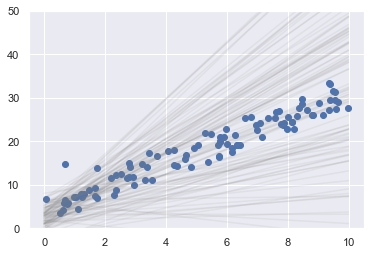

In [111]:
prior_alphas = np.random.normal(3,2, size=100)
prior_betas = np.random.normal(3,2, size=100)
ranges = np.array([0, 10])
for i in range(100):
  plt.plot(ranges, prior_alphas[i] + prior_betas[i] * ranges, color='gray', 
           alpha=0.1 )
plt.ylim(bottom=-0, top=50)
plt.scatter(x,y)
plt.show()

## Compile model

In [101]:
data = {
    'N': len(x),
    'x': x,
    'y': y
}

In [102]:
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b17fb0a345fb650d29cc22b3192cf968 NOW.


## Sample from posterior

In [103]:
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

## Summary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000246F931E708>,
      dtype=object)

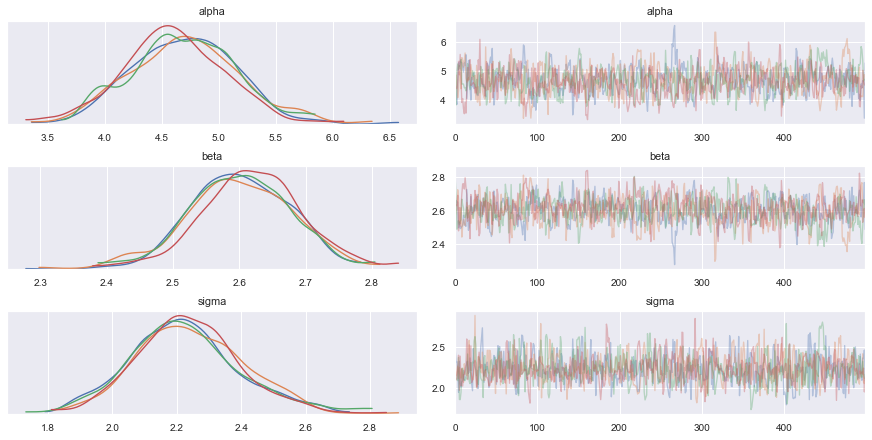

In [104]:
arviz.plot_trace(fit)

In [105]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

In [106]:
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,4.668171,0.018466,0.461546,3.805824,4.360921,4.660488,4.976618,5.629319,624.720419,1.007186
beta,2.604023,0.003162,0.076866,2.440779,2.552849,2.604465,2.657379,2.752809,591.116947,1.010196
sigma,2.231846,0.005248,0.168835,1.919656,2.117457,2.221113,2.333097,2.593645,1034.922550,1.003533
lp__,-129.110745,0.049854,1.288109,-132.414190,-129.714050,-128.776075,-128.166544,-127.671253,667.593868,1.000725


In [107]:
fit.to_dataframe()

,chain,draw,warmup,alpha,beta,sigma,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,5.287800,2.473244,2.459043,-130.043018,0.640230,0.401724,4,15,0,133.548579
1,0,1,0,3.961781,2.660443,2.315376,-129.723418,0.933969,0.401724,4,15,0,132.330925
2,0,2,0,3.837764,2.653701,2.320833,-131.149462,0.922120,0.401724,2,3,0,131.217453
3,0,3,0,4.468173,2.649813,2.211961,-127.785308,0.997348,0.401724,2,7,0,131.809877
4,0,4,0,5.279468,2.498415,1.941473,-130.314408,0.967495,0.401724,3,7,0,131.425158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,495,0,4.406537,2.662926,2.194268,-127.919751,0.913428,0.368045,2,3,0,128.488882
1996,3,496,0,5.021246,2.531037,2.167465,-128.021381,0.966287,0.368045,4,15,0,128.516475
1997,3,497,0,4.637167,2.601013,2.240376,-127.619924,0.948917,0.368045,4,15,0,128.635961
1998,3,498,0,4.531433,2.613640,1.947869,-129.178963,0.962311,0.368045,3,11,0,129.370990


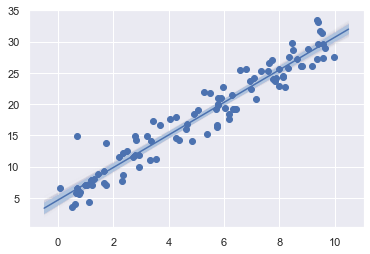

In [110]:
# Plotting regression line
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
shuffle = np.random.permutation(len(fit['alpha']))
post_alphas = fit['alpha'][shuffle]
post_betas = fit['beta'][shuffle]
for i in range(1000):
  plt.plot(x_plot, post_alphas[i] + post_betas[i] * x_plot, color='lightsteelblue', 
           alpha=0.005 )
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)
plt.show()

In [109]:
fit

Inference for Stan model: anon_model_b17fb0a345fb650d29cc22b3192cf968.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   4.67    0.02   0.46   3.81   4.36   4.66   4.98   5.63    625   1.01
beta     2.6  3.2e-3   0.08   2.44   2.55    2.6   2.66   2.75    591   1.01
sigma   2.23  5.2e-3   0.17   1.92   2.12   2.22   2.33   2.59   1035    1.0
lp__  -129.1    0.05   1.29 -132.4 -129.7 -128.7 -128.1 -127.6    668    1.0

Samples were drawn using NUTS at Sat May  2 02:23:58 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).